# All imports

In [1]:
import os
import numpy as np
import random
from tqdm import tqdm
import gymnasium as gym
from collections import deque, namedtuple
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

# w2v required
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity

# DQN required
import argparse
import numpy as np
# import logging
# from matplotlib import animation # will be needed for rendering

# All global variables needed
Since some or all of these variables are needed for each cell below, it's difficult to put these inside the main function.\
Perhaps, using some args method might work?

## Common Functions needed

### Function to generate custom map

In [2]:
# ============================================================================================
# Function to generate custom map
# ============================================================================================
def make_env(env_name, env_dim = 4, seed = 42, stochastic = False):
    env = gym.make(env_name, desc=generate_random_map(size=env_dim, seed=seed), 
                   is_slippery = stochastic, render_mode = 'rgb_array')
    return env

## Global Variables

In [16]:
'''
env_name: str
env_dim: int --> Dimension of the game: 4x4 or 8x8
seed
stochastic = boolean --> Whether we use is_slippery = True or False
 '''
env_name = "FrozenLake-v1"
env_dim = 4
stochastic = False
seed = 42
gamma = 0.99 # discount factor in Q computation
alpha = 0.1 # learning rate in the table
num_episodes_q_table = 100_000
convergence_threshold = 1e-4
epsilon_start = 1
epsilon_decay_q_table = 0.99995
epsilon_end = 0.01
check_env_details = True

# Creating the environment
env = make_env(env_name=env_name, env_dim=env_dim, seed = seed, stochastic=stochastic)
state_dim = env.observation_space.n
action_dim = env.action_space.n
print("State space: ", env.observation_space.n)
print("Action space: ", env.action_space.n)

# state and trajectories related variables
num_episodes_trajectories = 10_000
num_states = state_dim
num_actions = action_dim
max_eps_len = 100
modified = "perfect" # perfect - for perfect trajectories, random - for purely random trajectories or "medium" for the combined trajs

# w2v related variables
''' Potential values for embedding dimensions = {4, 8, 12, 16, 20, 32, 64} '''
# w2v hyperparameters
embed_dim = 32
window_size = 2
batch_size = 16
w2v_epochs = 50
w2v_lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DQN variables
parser = argparse.ArgumentParser()
parser.add_argument("--env", default="FrozenLake-v1")          # Gymnasium environment name # Default = MountainCar-v0
parser.add_argument("--seed", default=42, type=int)              # sets Gym, PyTorch and Numpy seeds
parser.add_argument("--n-episodes", default=2500, type=int)     # maximum number of training episodes
parser.add_argument("--batch-size", default=64, type=int)       # training batch size
parser.add_argument("--discount", default=0.99)                 # discount factor
parser.add_argument("--lr", default=5e-4)                       # learning rate
parser.add_argument("--tau", default=0.001)                     # soft update of target network
parser.add_argument("--max-size", default=int(1e5),type=int)    # experience replay buffer length
parser.add_argument("--update-freq", default=4, type=int)       # update frequency of target network
parser.add_argument("--gpu-index", default=0,type=int)		      # GPU index
parser.add_argument("--max-esp-len", default=100, type=int)    # maximum time of an episode
#exploration strategy
parser.add_argument("--epsilon-start", default=1)               # start value of epsilon
parser.add_argument("--epsilon-end", default=0.01)              # end value of epsilon
parser.add_argument("--epsilon-decay", default=0.995)           # decay value of epsilon
parser.add_argument("--save-filename", default = "dqn_w2v_FrozenLake-v1" )
args, unknown = parser.parse_known_args()

# Filename for saving purposes - common part for all files
filename = f"{env_name}_map_size_{env_dim}_stochastic_{stochastic}_seed_{seed}"

# This folder path will be used to store all the saved models and the associated data
runs_folder_path = "mdp/runs_frozen"

# Check if the folder exists
if not os.path.exists(runs_folder_path):
    # Create the folder
    os.makedirs(runs_folder_path)
    print(f"Folder '{runs_folder_path}' created successfully.")
else:
    print(f"Folder '{runs_folder_path}' already exists.")


State space:  16
Action space:  4
Folder 'mdp/runs_frozen' already exists.


# Tabular Q learning

### Q-Learning Agent class

In [28]:
# ============================================================================================
# Q-Learning Agent class
# ============================================================================================
class QLearningAgent:
    """Q-learning agent."""
    def __init__(self, num_states, num_actions, gamma=0.99, epsilon=0.1, alpha=0.1):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.q_table = np.zeros((num_states, num_actions))  # Initialize Q-table

    def choose_action(self, state, epsilon):
        """Epsilon-greedy action selection."""
        if random.uniform(0, 1) < epsilon:
            return random.randint(0, self.num_actions - 1)  # Explore
        else:
            return np.argmax(self.q_table[state, :])  # Exploit

    def update_q_value(self, state, action, reward, next_state):
        """Q-learning update rule."""
        best_next_action = np.argmax(self.q_table[next_state, :])  # Greedy action for next state
        td_target = reward + self.gamma * self.q_table[next_state, best_next_action]
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * td_error  # Update Q-table

    def get_optimal_policy(self):
        """Extracts the optimal policy after training."""
        return np.argmax(self.q_table, axis=1)

### Function to train the model using Q-learning for Frozen Lake

In [29]:
# ============================================================================================
# Function to train the model using Q-learning for Frozen Lake
# ============================================================================================
def run_tabular_q_frozen(env, agent, num_episodes=10, max_eps_len = 100, convergence_threshold=1e-4,
                         epsilon_start = 1, epsilon_decay = 0.995, epsilon_end = 0.01, seed=42):
    reward_curve = [] # this will store the moving avg of rewards
    moving_window = deque(maxlen=100)
    epsilon = epsilon_start
    prev_q_table = np.copy(agent.q_table)  # Store old Q-table

    for episode in tqdm(range(num_episodes)):
        state,_ = env.reset(seed=seed)
        # print(f"\nIn episode {episode}, After reset initial state = {state} and epsilon = {epsilon}")
        curr_reward = 0
        flag = False

        for _ in range(max_eps_len):
            action = agent.choose_action(state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            agent.update_q_value(state, action, reward, next_state)
            state = next_state
            curr_reward += reward

            # # Compute max Q-value change
            # q_change = np.max(np.abs(agent.q_table - prev_q_table))
            # prev_q_table = np.copy(agent.q_table)

            # # Check Q-value convergence
            # if q_change < convergence_threshold:
            #     print(f"Q-values converged at Episode {episode+1} with max Q-change: {q_change}")
            #     flag = True
            #     break

            if done:
                break
        # end while inside an episode
        
        # Epsilon decay performed at the end of each episode
        epsilon *= epsilon_decay
        epsilon = max(epsilon, epsilon_end)

        # Appending the smoothened reward
        moving_window.append(curr_reward)
        reward_curve.append(np.mean(moving_window))

        if episode % 1000 == 0:
            print(f"Tabular Q: Episode {episode}: epsilon = {epsilon}, avg reward = {np.mean(moving_window)}")
        # end if

        # if flag:
        #     break
    # end for num_episode

    return agent.q_table, agent.get_optimal_policy(), reward_curve

### Running the Tabular Q learning

In [30]:
# env = make_env(env_name=env_name, env_dim=env_dim, seed = seed, stochastic=stochastic)

# Setting seeds
np.random.seed(seed)
random.seed(seed)

if check_env_details:
    # Extract the environment description (grid layout)
    lake_grid = env.unwrapped.desc  # Gets the grid representation

    # Print state-to-symbol mapping
    print("Frozen Lake Grid Layout:")
    for row in lake_grid:
        print(" ".join(row.astype(str)))

    goal_state = None
    rows, cols = lake_grid.shape
    for i in range(rows):
        for j in range(cols):
            if lake_grid[i, j] == b'G':  # 'G' is stored as a byte-string
                goal_state = i * cols + j  # Convert (row, col) to state number
                break
        # end for j
    # end for i
    print(f"Goal State: {goal_state}")
# end if check_env

state_dim = env.observation_space.n
action_dim = env.action_space.n
print("State space: ", env.observation_space.n)
print("Action space: ", env.action_space.n)

learner = QLearningAgent(num_states=state_dim, num_actions=action_dim, gamma=gamma
                            , epsilon=epsilon_start, alpha=alpha) # Creating the learning Agent

final_q_table, final_policy, reward_curve = run_tabular_q_frozen(
                env, learner, num_episodes=num_episodes_q_table, max_eps_len=max_eps_len, convergence_threshold=convergence_threshold,
                epsilon_start = epsilon_start, epsilon_decay = epsilon_decay_q_table, epsilon_end = epsilon_end, seed=seed)

Val_f = np.max(final_q_table, axis=1)

state = 0
# Define action map
action_map = {
0: "Left",
1: "Down",
2: "Right",
3: "Up"
}
print("State: Type -    V(s),    action taken")
lake_grid = env.unwrapped.desc  # Gets the grid representation
for row in lake_grid:
    for cell in row:
        print(f"     {state}:   {cell.decode('utf-8')} - {Val_f[state]:.2f}, {final_policy[state]}-->{action_map[final_policy[state]]}")  # Convert byte to string
        state += 1
# assert False, "c1"

# Print the final table and policy
print("Final Q function: ", final_q_table)
# print("Final Policy: ", final_policy)
# print("Final Value function: ", Val_f)

# # Plot heatmap of the Value function
# plt.figure(figsize=(5,5))
# plt.imshow(Val_f.reshape(4,4), cmap="coolwarm", interpolation="nearest")
# for i in range(4):
#     for j in range(4):
#         plt.text(j, i, f"{Val_f[i*4+j]:.2f}", ha='center', va='center', color='black')


# Plot the reward curve



# Save the current Q-function
save_model = f"{runs_folder_path}/Q_table_{filename}.npy"
np.save(save_model, final_q_table)

Frozen Lake Grid Layout:
S H F F
F F F F
F H H F
F F F G
Goal State: 15
State space:  16
Action space:  4


  2%|▏         | 1822/100000 [00:00<00:05, 18193.17it/s]

Tabular Q: Episode 0: epsilon = 0.99995, avg reward = 0.0
Tabular Q: Episode 1000: epsilon = 0.9511806740132733, avg reward = 0.02
Tabular Q: Episode 2000: epsilon = 0.904789914112052, avg reward = 0.03
Tabular Q: Episode 3000: epsilon = 0.8606617134311852, avg reward = 0.01


  7%|▋         | 7316/100000 [00:00<00:05, 17792.42it/s]

Tabular Q: Episode 4000: epsilon = 0.8186857229650423, avg reward = 0.08
Tabular Q: Episode 5000: epsilon = 0.7787569756237134, avg reward = 0.12
Tabular Q: Episode 6000: epsilon = 0.7407756237474893, avg reward = 0.11
Tabular Q: Episode 7000: epsilon = 0.7046466894232127, avg reward = 0.07


 11%|█         | 10823/100000 [00:00<00:05, 16995.30it/s]

Tabular Q: Episode 8000: epsilon = 0.6702798269781429, avg reward = 0.17
Tabular Q: Episode 9000: epsilon = 0.6375890970574211, avg reward = 0.31
Tabular Q: Episode 10000: epsilon = 0.6064927517201779, avg reward = 0.28
Tabular Q: Episode 11000: epsilon = 0.5769130300168653, avg reward = 0.41


 14%|█▍        | 14206/100000 [00:00<00:05, 16736.85it/s]

Tabular Q: Episode 12000: epsilon = 0.5487759635366593, avg reward = 0.29
Tabular Q: Episode 13000: epsilon = 0.5220111914386566, avg reward = 0.42
Tabular Q: Episode 14000: epsilon = 0.49655178450431714, avg reward = 0.41
Tabular Q: Episode 15000: epsilon = 0.47233407777119996, avg reward = 0.46


 19%|█▉        | 19256/100000 [00:01<00:04, 16655.49it/s]

Tabular Q: Episode 16000: epsilon = 0.44929751132941503, avg reward = 0.56
Tabular Q: Episode 17000: epsilon = 0.4273844788827431, avg reward = 0.51
Tabular Q: Episode 18000: epsilon = 0.40654018369568434, avg reward = 0.51
Tabular Q: Episode 19000: epsilon = 0.3867125015662202, avg reward = 0.6


 23%|██▎       | 22582/100000 [00:01<00:04, 16506.13it/s]

Tabular Q: Episode 20000: epsilon = 0.367851850481642, avg reward = 0.58
Tabular Q: Episode 21000: epsilon = 0.34991106663148985, avg reward = 0.6
Tabular Q: Episode 22000: epsilon = 0.332845286467567, avg reward = 0.55
Tabular Q: Episode 23000: epsilon = 0.31661183451608793, avg reward = 0.63


 26%|██▌       | 25905/100000 [00:01<00:04, 16565.63it/s]

Tabular Q: Episode 24000: epsilon = 0.30117011666142574, avg reward = 0.61
Tabular Q: Episode 25000: epsilon = 0.286481518634604, avg reward = 0.75
Tabular Q: Episode 26000: epsilon = 0.2725093094526817, avg reward = 0.68
Tabular Q: Episode 27000: epsilon = 0.259218549567572, avg reward = 0.78


 31%|███       | 30958/100000 [00:01<00:04, 16781.77it/s]

Tabular Q: Episode 28000: epsilon = 0.246576003494601, avg reward = 0.63
Tabular Q: Episode 29000: epsilon = 0.23455005670232934, avg reward = 0.78
Tabular Q: Episode 30000: epsilon = 0.22311063655580088, avg reward = 0.71
Tabular Q: Episode 31000: epsilon = 0.21222913711553318, avg reward = 0.74


 34%|███▍      | 34347/100000 [00:02<00:03, 16616.70it/s]

Tabular Q: Episode 32000: epsilon = 0.20187834760418902, avg reward = 0.85
Tabular Q: Episode 33000: epsilon = 0.19203238436205666, avg reward = 0.8
Tabular Q: Episode 34000: epsilon = 0.18266662612118353, avg reward = 0.84
Tabular Q: Episode 35000: epsilon = 0.17375765243629993, avg reward = 0.78


 38%|███▊      | 37834/100000 [00:02<00:03, 17040.26it/s]

Tabular Q: Episode 36000: epsilon = 0.16528318511857973, avg reward = 0.75
Tabular Q: Episode 37000: epsilon = 0.15722203252577774, avg reward = 0.82
Tabular Q: Episode 38000: epsilon = 0.14955403656943475, avg reward = 0.85
Tabular Q: Episode 39000: epsilon = 0.14226002230663626, avg reward = 0.82


 43%|████▎     | 43064/100000 [00:02<00:03, 17304.99it/s]

Tabular Q: Episode 40000: epsilon = 0.1353217499902697, avg reward = 0.93
Tabular Q: Episode 41000: epsilon = 0.12872186945787317, avg reward = 0.86
Tabular Q: Episode 42000: epsilon = 0.12244387674502544, avg reward = 0.85
Tabular Q: Episode 43000: epsilon = 0.11647207281477254, avg reward = 0.9


 47%|████▋     | 46569/100000 [00:02<00:03, 17425.07it/s]

Tabular Q: Episode 44000: epsilon = 0.11079152429989349, avg reward = 0.84
Tabular Q: Episode 45000: epsilon = 0.10538802615983875, avg reward = 0.81
Tabular Q: Episode 46000: epsilon = 0.10024806615895202, avg reward = 0.92
Tabular Q: Episode 47000: epsilon = 0.09535879107715316, avg reward = 0.93


 50%|█████     | 50109/100000 [00:02<00:02, 17570.85it/s]

Tabular Q: Episode 48000: epsilon = 0.09070797456858609, avg reward = 0.88
Tabular Q: Episode 49000: epsilon = 0.08628398658785626, avg reward = 0.9
Tabular Q: Episode 50000: epsilon = 0.08207576430740496, avg reward = 0.88
Tabular Q: Episode 51000: epsilon = 0.07807278445329505, avg reward = 0.89


 55%|█████▌    | 55476/100000 [00:03<00:02, 17798.98it/s]

Tabular Q: Episode 52000: epsilon = 0.07426503699022786, avg reward = 0.95
Tabular Q: Episode 53000: epsilon = 0.07064300008999028, avg reward = 0.85
Tabular Q: Episode 54000: epsilon = 0.06719761632073298, avg reward = 0.9
Tabular Q: Episode 55000: epsilon = 0.06392026999754027, avg reward = 0.93


 59%|█████▉    | 59053/100000 [00:03<00:02, 17841.56it/s]

Tabular Q: Episode 56000: epsilon = 0.06080276563765279, avg reward = 0.91
Tabular Q: Episode 57000: epsilon = 0.05783730746646704, avg reward = 0.91
Tabular Q: Episode 58000: epsilon = 0.05501647992306336, avg reward = 0.94
Tabular Q: Episode 59000: epsilon = 0.05233322911651293, avg reward = 0.92


 63%|██████▎   | 62632/100000 [00:03<00:02, 17760.98it/s]

Tabular Q: Episode 60000: epsilon = 0.04978084518659529, avg reward = 0.95
Tabular Q: Episode 61000: epsilon = 0.04735294552481254, avg reward = 0.96
Tabular Q: Episode 62000: epsilon = 0.0450434588137458, avg reward = 0.97
Tabular Q: Episode 63000: epsilon = 0.04284660984484019, avg reward = 1.0


 66%|██████▌   | 66215/100000 [00:03<00:01, 17839.30it/s]

Tabular Q: Episode 64000: epsilon = 0.04075690507665269, avg reward = 0.96
Tabular Q: Episode 65000: epsilon = 0.03876911889745041, avg reward = 0.97
Tabular Q: Episode 66000: epsilon = 0.03687828055780553, avg reward = 0.96
Tabular Q: Episode 67000: epsilon = 0.03507966174051114, avg reward = 0.95


 72%|███████▏  | 71603/100000 [00:04<00:01, 17924.05it/s]

Tabular Q: Episode 68000: epsilon = 0.03336876473673393, avg reward = 0.99
Tabular Q: Episode 69000: epsilon = 0.031741311198836865, avg reward = 0.98
Tabular Q: Episode 70000: epsilon = 0.03019323144174688, avg reward = 0.99
Tabular Q: Episode 71000: epsilon = 0.0287206542661129, avg reward = 0.99


 75%|███████▌  | 75210/100000 [00:04<00:01, 17974.78it/s]

Tabular Q: Episode 72000: epsilon = 0.027319897277807384, avg reward = 0.98
Tabular Q: Episode 73000: epsilon = 0.025987457679562245, avg reward = 0.99
Tabular Q: Episode 74000: epsilon = 0.02472000351171302, avg reward = 0.98
Tabular Q: Episode 75000: epsilon = 0.0235143653201477, avg reward = 0.98


 79%|███████▉  | 78804/100000 [00:04<00:01, 17949.70it/s]

Tabular Q: Episode 76000: epsilon = 0.02236752823062398, avg reward = 0.99
Tabular Q: Episode 77000: epsilon = 0.021276624409636378, avg reward = 0.96
Tabular Q: Episode 78000: epsilon = 0.0202389258929799, avg reward = 0.96
Tabular Q: Episode 79000: epsilon = 0.019251837764077552, avg reward = 0.98


 82%|████████▏ | 82414/100000 [00:04<00:00, 17988.16it/s]

Tabular Q: Episode 80000: epsilon = 0.018312891665012748, avg reward = 1.0
Tabular Q: Episode 81000: epsilon = 0.017419739624040163, avg reward = 0.99
Tabular Q: Episode 82000: epsilon = 0.016570148184139464, avg reward = 0.97
Tabular Q: Episode 83000: epsilon = 0.015761992817930556, avg reward = 0.99


 86%|████████▌ | 86010/100000 [00:04<00:00, 17842.49it/s]

Tabular Q: Episode 84000: epsilon = 0.014993252614982331, avg reward = 0.98
Tabular Q: Episode 85000: epsilon = 0.014262005228231584, avg reward = 0.97
Tabular Q: Episode 86000: epsilon = 0.01356642206687351, avg reward = 1.0
Tabular Q: Episode 87000: epsilon = 0.012904763723703517, avg reward = 1.0


 91%|█████████▏| 91447/100000 [00:05<00:00, 18045.94it/s]

Tabular Q: Episode 88000: epsilon = 0.012275375625475645, avg reward = 0.98
Tabular Q: Episode 89000: epsilon = 0.011676683895400804, avg reward = 1.0
Tabular Q: Episode 90000: epsilon = 0.011107191417438142, avg reward = 1.0
Tabular Q: Episode 91000: epsilon = 0.010565474092537885, avg reward = 0.99


 95%|█████████▌| 95085/100000 [00:05<00:00, 18121.01it/s]

Tabular Q: Episode 92000: epsilon = 0.010050177277473855, avg reward = 1.0
Tabular Q: Episode 93000: epsilon = 0.01, avg reward = 1.0
Tabular Q: Episode 94000: epsilon = 0.01, avg reward = 0.96
Tabular Q: Episode 95000: epsilon = 0.01, avg reward = 0.97


 99%|█████████▊| 98700/100000 [00:05<00:00, 18000.17it/s]

Tabular Q: Episode 96000: epsilon = 0.01, avg reward = 1.0
Tabular Q: Episode 97000: epsilon = 0.01, avg reward = 1.0
Tabular Q: Episode 98000: epsilon = 0.01, avg reward = 1.0
Tabular Q: Episode 99000: epsilon = 0.01, avg reward = 0.99


100%|██████████| 100000/100000 [00:05<00:00, 17482.77it/s]

State: Type -    V(s),    action taken
     0:   S - 0.95, 1-->Down
     1:   H - 0.00, 0-->Left
     2:   F - 0.93, 1-->Down
     3:   F - 0.92, 1-->Down
     4:   F - 0.96, 1-->Down
     5:   F - 0.95, 0-->Left
     6:   F - 0.94, 0-->Left
     7:   F - 0.93, 0-->Left
     8:   F - 0.97, 1-->Down
     9:   H - 0.00, 0-->Left
     10:   H - 0.00, 0-->Left
     11:   F - 0.94, 1-->Down
     12:   F - 0.98, 2-->Right
     13:   F - 0.99, 2-->Right
     14:   F - 1.00, 2-->Right
     15:   G - 0.00, 0-->Left
Final Q function:  [[0.94148015 0.95099005 0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.93205586 0.87474419 0.90862408]
 [0.86271014 0.92179288 0.87716587 0.80318285]
 [0.95099005 0.96059601 0.94148015 0.94148015]
 [0.95099005 0.         0.93206535 0.        ]
 [0.94148015 0.         0.92274081 0.92271159]
 [0.93206502 0.85285683 0.91736803 0.89972552]
 [0.96059601 0.970299   0.         0.95099005]
 [0.         0.         0.         0.        ]

# Collecting Trajectories
Here we may need to ensure that the trajectories sufficiently explore each state.\
Thus, we may want to start from specific states when reseting the environment during trajectory collection.

In [31]:
def choose_action(q_table, state, epsilon):
    """Epsilon-greedy action selection."""
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, num_actions - 1)  # Explore
    else:
        return np.argmax(q_table[state, :])  # Exploit

In [32]:
q_table = np.load(f"{runs_folder_path}/Q_table_{filename}.npy")
# env = make_env(env_name=env_name, env_dim=env_dim, seed = seed, stochastic=stochastic)
flag = False
traj = []
tuple_traj = False
for e in tqdm(range(num_episodes_trajectories)):
    if modified=="perfect":
        _, _ = env.reset()
        epsilon = 0.01
        state = int(e%16)
        if flag==False:
            print(f"We're dealing with {modified} trajs!")
            flag = True
    # end if perfect

    elif modified=="random":
        epsilon = 1
        if random.uniform(0, 1) < 0.1:
            if random.uniform(0, 1) < 0.5:
                state = 3
            elif random.uniform(0, 1) < 0.65:
                state = 6
            else:
                state = 7
            # end if choosing state
        else:
            state, _ = env.reset(seed=seed)
        
        if flag==False:
            print(f"We're dealing with {modified} trajs!")
            flag = True
    # end if random trajectories
    
    else:
        # continue    
        if e<0.1*num_episodes_trajectories:
          epsilon = 1
        elif e<0.2*num_episodes_trajectories:
          epsilon = 0.8
        elif e<0.3*num_episodes_trajectories:
          epsilon = 0.6
        elif e<0.4*num_episodes_trajectories:
          epsilon = 0.4
        elif e<0.5*num_episodes_trajectories:
          epsilon = 0.2
        elif e<0.6*num_episodes_trajectories:
          epsilon = 0.1
        elif e<0.7*num_episodes_trajectories:
          epsilon = 0.05
        else:
          epsilon = 0.01
        # end epsilon if
        if random.uniform(0, 1) < 0.1:
            state, _ = env.reset(seed=seed)
            if random.uniform(0, 1) < 0.5:
                state = 3
            elif random.uniform(0, 1) < 0.65:
                state = 6
            else:
                state = 7
            # end if choosing state
        else:
            state, _ = env.reset(seed=seed)
        
        if flag==False:
            print(f"We're dealing with {modified} trajs!")
            flag = True
        # end flag if
    
    if not tuple_traj:
       traj.append('s_'+str(state))
    '''
    Action Stochasticity (is_slippery=True): The seed affects how the agent slips 
    (randomly moves instead of following the chosen action).
    Random Hole Placement (if map is generated dynamically): If the map has random 
    elements, different seeds can affect the placement of H (holes).
    '''
    curr_reward = 0
    rep_count = 0
    for t in range(max_eps_len):
      action = choose_action(q_table, state, epsilon) #To be implemented
      n_state,reward,done,_,_ = env.step(action)
      
      # We store the current tuple
      if tuple_traj:
        traj.append((state, action, reward, n_state, done))
      else:
        temp = 's_'+str(n_state)
        # traj.append('s_'+str(n_state))
        traj.append(temp)

      state = n_state
      curr_reward += reward
      if done:
        if rep_count>=5: # This forces repetitions to occur when done becomes True thereby repeating ending states
            if not tuple_traj:
                if temp=='s_15':
                    traj.append('s_'+str(16))
                else:
                    traj.append('s_'+str(17))
            break
        else:
            if not tuple_traj:
                traj.append(temp)
        rep_count+=1
    # end for
# end for
if tuple_traj:
    save_file_name = f"{runs_folder_path}/modified_tuple_trajectories_{filename}.npy"
    np.save(save_file_name, traj)
else:
    save_file_name = f"{runs_folder_path}/modified_{modified}_trajectories_{filename}.npy"
    np.save(save_file_name, traj)
print(f"Trajectories Saved in {save_file_name}!")

# assert False, "No w2v business here"

  0%|          | 0/10000 [00:00<?, ?it/s]

 16%|█▋        | 1646/10000 [00:00<00:00, 16459.51it/s]

We're dealing with medium trajs!


100%|██████████| 10000/10000 [00:00<00:00, 15732.60it/s]

Trajectories Saved in mdp/runs_frozen/modified_medium_trajectories_FrozenLake-v1_map_size_4_stochastic_False_seed_19.npy!


# Performing w2v

In [33]:
traj_file = f"{runs_folder_path}/modified_{modified}_trajectories_{filename}.npy"
print("The trajectories being used are: ", traj_file)

text = np.load(traj_file)
np.random.seed(seed=seed)
torch.manual_seed(seed)

The trajectories being used are:  mdp/runs_frozen/modified_medium_trajectories_FrozenLake-v1_map_size_4_stochastic_False_seed_19.npy


### Now we define the functions for word2vec algorithm

In [34]:
def build_vocab(text): # Again we already have a vocabulary hence don't need to use this function directly
    word_counts = Counter(text)
    vocab = {word: i for i, word in enumerate(word_counts.keys())}
    reverse_vocab = {i: word for word, i in vocab.items()}
    return vocab, reverse_vocab, word_counts

def generate_skipgram_pairs(text, window_size=2): # This function gives the word and context pairs.
    # words = tokenize_text(text)
    words = text
    pairs = []
    for i, target_word in enumerate(words):
        window_start = max(i - window_size, 0)
        window_end = min(i + window_size + 1, len(words))
        for j in range(window_start, window_end):
            if i != j:
                pairs.append((words[i], words[j]))
    return pairs

vocab,_,wcounts = build_vocab(text)
print("vocab: ", vocab)
print("word counts: ", wcounts)
# assert False, "Checking the word counts!"

vocab:  {'s_0': 0, 's_1': 1, 's_17': 2, 's_4': 3, 's_5': 4, 's_3': 5, 's_9': 6, 's_6': 7, 's_2': 8, 's_8': 9, 's_12': 10, 's_7': 11, 's_11': 12, 's_15': 13, 's_16': 14, 's_13': 15, 's_14': 16, 's_10': 17}
word counts:  Counter({'s_15': 71049, 's_1': 20350, 's_9': 14432, 's_0': 13459, 's_4': 11503, 's_8': 9818, 's_12': 9331, 's_13': 8268, 's_14': 7308, 's_16': 6459, 's_10': 4169, 's_17': 3541, 's_5': 1145, 's_6': 598, 's_3': 564, 's_7': 299, 's_2': 82, 's_11': 50})


### Word2vec class definition

In [35]:
# ============================================================================================
# Classes: Word2vec Dataset creator and SkipGram model
# ============================================================================================

class Word2VecDataset(Dataset):
    def __init__(self, text, vocab, window_size=2):
        self.vocab = vocab
        self.data = generate_skipgram_pairs(text, window_size)
        self.vocab_size = len(vocab) # why is this needed here?

    def __len__(self): # what does this function do?
        return len(self.data)

    def __getitem__(self, idx):
        target, context = self.data[idx]
        ''' Doesn't the above idx reflect the idx numbered pair instead in pairs instead of the pairs
        corresponding to the word at idx? '''
        target_idx = torch.tensor(self.vocab[target], dtype=torch.long)
        context_idx = torch.tensor(self.vocab[context], dtype=torch.long)
        # target_idx = self.vocab[target]
        # context_idx = self.vocab[context]

        return target_idx, context_idx
    

    # ============================================================================================
# Class: SkipGram using softmax over entire vocabulary
# ============================================================================================

class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embedding_dim = embedding_dim

        # Input word embedding
        self.in_embedding = nn.Embedding(vocab_size, embedding_dim)
        # Output word embedding (used for context words)
        self.out_embedding = nn.Embedding(vocab_size, embedding_dim)

        # Initialize weights (better stability)
        init_range = 0.5 / embedding_dim
        self.in_embedding.weight.data.uniform_(-init_range, init_range)
        self.out_embedding.weight.data.uniform_(-init_range, init_range)

    def forward(self, center_word_idx):
        """Compute word embeddings and softmax probabilities for the context words."""
        center_embed = F.relu(self.in_embedding(center_word_idx))  # Shape: (batch_size, embedding_dim)
        scores = torch.matmul(center_embed, self.out_embedding.weight.T)  # Compute dot product
        y_pred = torch.softmax(scores, dim=1)  # Apply softmax over output vocab
        return y_pred

    def get_word_vector(self, word_idx):
        """Return the learned embedding vector for a given word index."""
        return self.in_embedding(word_idx).detach().cpu().numpy()

### Training function

In [36]:
# ============================================================================================
# Function: to train the w2v skipgram model
# ============================================================================================

def train_skipgram(model, data_loader, epochs=6, lr=0.01, device = device):
    """Train the SkipGram model using Adam optimizer."""
    criterion = nn.CrossEntropyLoss()  # Cross-entropy for multi-class classification
    optimizer = optim.Adam(model.parameters(), lr)

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for center_word_idx, context_word_idx in data_loader:
            center_word_idx = center_word_idx.to(device)
            context_word_idx = context_word_idx.to(device)

            optimizer.zero_grad()
            y_pred = model(center_word_idx)  # Forward pass
            loss = criterion(y_pred, context_word_idx)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    return model

### Main function for w2v

In [37]:
# ============================================================================================
#  Main function for calling the w2v agent
# ============================================================================================
# First we create the dataset and dataloader
vocab, _, _ = build_vocab(text)
dataset = Word2VecDataset(text, vocab, window_size)
dataloader = DataLoader(dataset, batch_size, shuffle=True)
model = SkipGram(vocab_size=len(vocab), embedding_dim=embed_dim).to(device)
model = train_skipgram(model, dataloader, epochs = w2v_epochs, lr = w2v_lr)

# ============================================================================================
#  Saving the w2v generated vector embeddings as a dictionary
# ============================================================================================
word_embeddings = {}
for word in vocab:
    word_idx = torch.tensor([vocab[word]], dtype=torch.long).to(device)
    updated_embedding = model.get_word_vector(word_idx)
    # print(f"Updated embedding for '{word}': {updated_embedding}")
    # Store the embedding in the dictionary
    word_embeddings[word] = updated_embedding.flatten()  # Flatten to 1D array

# Saving the w2v model
save_w2v_file = f"{runs_folder_path}/modified_{modified}_w2v_embed_dim_{embed_dim}_{filename}_epochs_{w2v_epochs}.npy"
np.save(save_w2v_file, word_embeddings)
print("W2v vetors stored in: ", save_w2v_file)

  2%|▏         | 1/60 [00:14<14:37, 14.87s/it]

Epoch 1, Loss: 106778.1975


  3%|▎         | 2/60 [00:30<14:40, 15.18s/it]

Epoch 2, Loss: 107378.3121


  5%|▌         | 3/60 [00:44<14:08, 14.88s/it]

Epoch 3, Loss: 107758.1641


  7%|▋         | 4/60 [01:00<14:14, 15.26s/it]

Epoch 4, Loss: 108270.3071


  8%|▊         | 5/60 [01:15<13:46, 15.03s/it]

Epoch 5, Loss: 110770.9742


 10%|█         | 6/60 [01:29<13:21, 14.84s/it]

Epoch 6, Loss: 110771.2706


 12%|█▏        | 7/60 [01:44<13:00, 14.72s/it]

Epoch 7, Loss: 110771.5452


 13%|█▎        | 8/60 [01:58<12:43, 14.68s/it]

Epoch 8, Loss: 110770.4766


 15%|█▌        | 9/60 [02:15<12:54, 15.18s/it]

Epoch 9, Loss: 110769.4992


 17%|█▋        | 10/60 [02:29<12:28, 14.98s/it]

Epoch 10, Loss: 110770.4439


 18%|█▊        | 11/60 [02:44<12:07, 14.85s/it]

Epoch 11, Loss: 110783.5341


 20%|██        | 12/60 [02:58<11:48, 14.77s/it]

Epoch 12, Loss: 110928.8452


 22%|██▏       | 13/60 [03:13<11:31, 14.71s/it]

Epoch 13, Loss: 111626.2636


 23%|██▎       | 14/60 [03:29<11:32, 15.05s/it]

Epoch 14, Loss: 111670.7764


 25%|██▌       | 15/60 [03:43<11:12, 14.95s/it]

Epoch 15, Loss: 111669.1654


 27%|██▋       | 16/60 [04:00<11:15, 15.35s/it]

Epoch 16, Loss: 111669.8475


 28%|██▊       | 17/60 [04:16<11:08, 15.54s/it]

Epoch 17, Loss: 111671.2268


 30%|███       | 18/60 [04:30<10:38, 15.21s/it]

Epoch 18, Loss: 111670.5253


 32%|███▏      | 19/60 [04:45<10:14, 14.98s/it]

Epoch 19, Loss: 111670.3084


 33%|███▎      | 20/60 [04:59<09:54, 14.85s/it]

Epoch 20, Loss: 111672.1859


 35%|███▌      | 21/60 [05:15<09:53, 15.21s/it]

Epoch 21, Loss: 111670.4128


 37%|███▋      | 22/60 [05:31<09:49, 15.51s/it]

Epoch 22, Loss: 111671.0078


 38%|███▊      | 23/60 [05:47<09:31, 15.43s/it]

Epoch 23, Loss: 111670.0712


 40%|████      | 24/60 [06:01<09:05, 15.15s/it]

Epoch 24, Loss: 111670.1736


 42%|████▏     | 25/60 [06:16<08:43, 14.96s/it]

Epoch 25, Loss: 111671.0787


 43%|████▎     | 26/60 [06:31<08:30, 15.02s/it]

Epoch 26, Loss: 111669.6143


 45%|████▌     | 27/60 [06:46<08:20, 15.17s/it]

Epoch 27, Loss: 111669.7187


 47%|████▋     | 28/60 [07:01<08:00, 15.00s/it]

Epoch 28, Loss: 111671.8555


 48%|████▊     | 29/60 [07:15<07:40, 14.87s/it]

Epoch 29, Loss: 111670.1345


 50%|█████     | 30/60 [07:31<07:28, 14.94s/it]

Epoch 30, Loss: 111671.6854


 52%|█████▏    | 31/60 [07:46<07:20, 15.18s/it]

Epoch 31, Loss: 111671.4592


 53%|█████▎    | 32/60 [08:01<07:02, 15.09s/it]

Epoch 32, Loss: 111670.9874


 55%|█████▌    | 33/60 [08:16<06:42, 14.92s/it]

Epoch 33, Loss: 111671.3069


 57%|█████▋    | 34/60 [08:31<06:26, 14.88s/it]

Epoch 34, Loss: 111670.1011


 58%|█████▊    | 35/60 [08:46<06:19, 15.18s/it]

Epoch 35, Loss: 111671.3223


 60%|██████    | 36/60 [09:02<06:05, 15.24s/it]

Epoch 36, Loss: 111671.7183


 62%|██████▏   | 37/60 [09:17<05:48, 15.13s/it]

Epoch 37, Loss: 111669.1855


 63%|██████▎   | 38/60 [09:32<05:33, 15.15s/it]

Epoch 38, Loss: 111670.7458


 65%|██████▌   | 39/60 [09:46<05:14, 14.96s/it]

Epoch 39, Loss: 111671.7902


 67%|██████▋   | 40/60 [10:02<05:04, 15.20s/it]

Epoch 40, Loss: 111670.4769


 68%|██████▊   | 41/60 [10:18<04:52, 15.38s/it]

Epoch 41, Loss: 111671.5779


 70%|███████   | 42/60 [10:33<04:33, 15.20s/it]

Epoch 42, Loss: 111669.5946


 72%|███████▏  | 43/60 [10:47<04:15, 15.01s/it]

Epoch 43, Loss: 111670.1388


 73%|███████▎  | 44/60 [11:02<04:00, 15.03s/it]

Epoch 44, Loss: 111669.6485


 75%|███████▌  | 45/60 [11:18<03:47, 15.16s/it]

Epoch 45, Loss: 111670.5421


 77%|███████▋  | 46/60 [11:33<03:32, 15.16s/it]

Epoch 46, Loss: 111671.4291


 78%|███████▊  | 47/60 [11:47<03:14, 14.96s/it]

Epoch 47, Loss: 111671.6211


 80%|████████  | 48/60 [12:02<02:57, 14.79s/it]

Epoch 48, Loss: 111669.7771


 82%|████████▏ | 49/60 [12:17<02:42, 14.76s/it]

Epoch 49, Loss: 111671.0908


 83%|████████▎ | 50/60 [12:32<02:28, 14.87s/it]

Epoch 50, Loss: 111672.0286


 85%|████████▌ | 51/60 [12:46<02:13, 14.82s/it]

Epoch 51, Loss: 111671.4853


 87%|████████▋ | 52/60 [13:02<01:59, 14.93s/it]

Epoch 52, Loss: 111669.6896


 88%|████████▊ | 53/60 [13:16<01:43, 14.80s/it]

Epoch 53, Loss: 111670.7481


 90%|█████████ | 54/60 [13:32<01:31, 15.27s/it]

Epoch 54, Loss: 111670.6023


 92%|█████████▏| 55/60 [13:49<01:17, 15.55s/it]

Epoch 55, Loss: 111670.3756


 93%|█████████▎| 56/60 [14:05<01:02, 15.75s/it]

Epoch 56, Loss: 111671.0371


 95%|█████████▌| 57/60 [14:20<00:46, 15.47s/it]

Epoch 57, Loss: 111671.5524


 97%|█████████▋| 58/60 [14:34<00:30, 15.19s/it]

Epoch 58, Loss: 111671.0660


 98%|█████████▊| 59/60 [14:49<00:14, 15.00s/it]

Epoch 59, Loss: 111671.7636


100%|██████████| 60/60 [15:04<00:00, 15.07s/it]

Epoch 60, Loss: 111669.5790
W2v vetors stored in:  mdp/runs_frozen/modified_medium_w2v_embed_dim_32_FrozenLake-v1_map_size_4_stochastic_False_seed_19_epochs_60.npy


### Similarity check

In [38]:
# ============================================================================================
# Similarity checking and visualizing 
# ============================================================================================
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# Load saved embeddings
word_embeddings = np.load(f"{runs_folder_path}/modified_{modified}_w2v_embed_dim_{embed_dim}_{filename}_epochs_{w2v_epochs}.npy", 
                          allow_pickle=True).item()

# Convert to a NumPy array for fast computation
words = list(word_embeddings.keys())
vectors = np.array(list(word_embeddings.values()))

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(vectors)

# Function to find top-N similar words
def find_similar_words(target_word, top_n=5):
    if target_word not in word_embeddings:
        print(f"Word '{target_word}' not found in vocabulary.")
        return []

    # Get index of target word
    target_idx = words.index(target_word)

    # Get similarity scores for the target word
    similarity_scores = cosine_sim_matrix[target_idx]

    # Get top-N most similar words (excluding itself)
    similar_indices = np.argsort(similarity_scores)[::-1][1:top_n+1]  # Sort in descending order

    # Return words with their similarity scores
    return [(words[i], similarity_scores[i]) for i in similar_indices]

# Example usage
for target_word in word_embeddings:
    top_similar_words = find_similar_words(target_word, top_n=5)

    print(f"Top 5 words similar to '{target_word}':")
    for word, score in top_similar_words:
        print(f"{word}: {score:.4f}")

Top 5 words similar to 's_0':
s_16: 0.3311
s_5: 0.2516
s_14: 0.2308
s_10: 0.1650
s_17: 0.1143
Top 5 words similar to 's_1':
s_16: 0.4612
s_15: 0.3440
s_5: 0.2714
s_14: 0.2248
s_9: 0.2085
Top 5 words similar to 's_17':
s_11: 0.4657
s_3: 0.3402
s_12: 0.2826
s_7: 0.2539
s_6: 0.2521
Top 5 words similar to 's_4':
s_3: 0.1652
s_2: 0.1061
s_10: 0.0818
s_17: 0.0530
s_8: 0.0292
Top 5 words similar to 's_5':
s_1: 0.2714
s_0: 0.2516
s_16: 0.1861
s_14: 0.1738
s_10: 0.1343
Top 5 words similar to 's_3':
s_2: 0.5286
s_12: 0.4804
s_7: 0.4302
s_8: 0.4241
s_11: 0.3859
Top 5 words similar to 's_9':
s_10: 0.3926
s_14: 0.3843
s_13: 0.3406
s_15: 0.2164
s_1: 0.2085
Top 5 words similar to 's_6':
s_7: 0.4700
s_11: 0.4321
s_2: 0.4204
s_3: 0.3074
s_17: 0.2521
Top 5 words similar to 's_2':
s_7: 0.5352
s_3: 0.5286
s_12: 0.4711
s_6: 0.4204
s_11: 0.3958
Top 5 words similar to 's_8':
s_11: 0.4420
s_3: 0.4241
s_12: 0.2163
s_6: 0.1660
s_17: 0.1589
Top 5 words similar to 's_12':
s_3: 0.4804
s_2: 0.4711
s_11: 0.3197
s_7:

# Now we need to ensure that the same states are sampled to compare the performance of w2v imbued DQN and Vanilla DQN. 
Thus we reset np, random and torch.manual_seed before starting both the following cells

# DQN common set up

### Defining all classes
We define the following classes:
1. Experience Replay
2. DQNAgent 

In [17]:
class ExperienceReplay:
	"""
	Based on the Replay Buffer implementation of TD3
	Reference: https://github.com/sfujim/TD3/blob/master/utils.py
	"""
	def __init__(self, state_dim, action_dim,max_size,batch_size,gpu_index=0):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0
		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.done = np.zeros((max_size, 1))
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


	def add(self, state, action,reward,next_state, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.done[self.ptr] = done
		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)

	def sample(self):
		ind = np.random.randint(0, self.size, size=self.batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).long().to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.done[ind]).to(self.device)
		)



## Class of QNetwork with w2v
Here, the w2v input is given to a 2 layer NN. We remove the 64x64 layer since word vectors are already learnt and thus we don't require that layer

In [18]:
class w2v_QNetwork(nn.Module):
  """
  Q Network: designed to take state as input and give out Q values of actions as output
  """

  def __init__(self, state_dim, action_dim):
    """
      state_dim (int): state dimenssion
      action_dim (int): action dimenssion
    """
    super(w2v_QNetwork, self).__init__()
    self.l1 = nn.Linear(state_dim, 64)
    # self.l2 = nn.Linear(64, 64)
    self.l3 = nn.Linear(64, action_dim)

  def forward(self, state):
    q = F.relu(self.l1(state))
    # q = F.relu(self.l2(q))
    return self.l3(q)


### DQNAgent class

In [19]:
class w2v_DQNAgent():
  def __init__(self,
   embed_dim,
   action_dim,
   discount=0.99,
   tau=1e-3,
   lr=5e-4,
   update_freq=4,
   max_size=int(1e5),
   batch_size=64,
   gpu_index=0
   ):
    """
      state_size (int): dimension of each state
      action_size (int): dimension of each action
      discount (float): discount factor
      tau (float): used to update q-target
      lr (float): learning rate
      update_freq (int): update frequency of target network
      max_size (int): experience replay buffer size
      batch_size (int): training batch size
      gpu_index (int): GPU used for training
    """
    self.embed_dim = embed_dim
    self.action_dim = action_dim
    self.discount = discount
    self.tau = tau
    self.lr = lr
    self.update_freq = update_freq
    self.batch_size = batch_size
    self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


    # Setting up the NNs
    self.Q = w2v_QNetwork(embed_dim, action_dim).to(self.device)
    self.Q_target = w2v_QNetwork(embed_dim, action_dim).to(self.device)
    self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

    # Experience Replay Buffer
    self.memory = ExperienceReplay(embed_dim,1,max_size,self.batch_size,gpu_index)

    self.t_train = 0

  def step(self, state, action, reward, next_state, done):
    """
    1. Adds (s,a,r,s') to the experience replay buffer, and updates the networks
    2. Learns when the experience replay buffer has enough samples
    3. Updates target netowork
    """
    self.memory.add(state, action, reward, next_state, done)
    self.t_train += 1

    if self.memory.size > self.batch_size:
      experiences = self.memory.sample()
      self.learn(experiences, self.discount) #To be implemented

    if (self.t_train % self.update_freq) == 0:
      self.target_update(self.Q, self.Q_target, self.tau) #To be implemented

  def select_action(self, state, epsilon):
    """
    TODO: Complete this block to select action using epsilon greedy exploration
    strategy
    Input: state, epsilon
    Return: Action
    Return Type: int
    """
    ###### TYPE YOUR CODE HERE ######
    # We generate a random number between 0 and 1
    rand_num = np.random.random()
    state = torch.from_numpy(state).to(self.device)
    a_opt = np.argmax(self.Q(state).cpu().detach().numpy())
    if rand_num<epsilon:
      a_list = [y for y in range(self.action_dim)]
      # print('a_list = ', a_list)
      a_list.remove(a_opt)
      # print('a_list = ', a_list)
      at = np.random.choice(np.array(a_list))
      return (at)
    else:
      return(a_opt)
    #################################

  def learn(self, experiences, discount):
    """
    TODO: Complete this block to update the Q-Network using the target network
    1. Compute target using  self.Q_target ( target = r + discount * max_b [Q_target(s,b)] )
    2. Compute Q(s,a) using self.Q
    3. Compute MSE loss between step 1 and step 2
    4. Update your network
    Input: experiences consisting of states,actions,rewards,next_states and discount factor
    Return: None
    """
    states, actions, rewards, next_states, dones = experiences
    ###### TYPE YOUR CODE HERE ######
    # Step 1:
    target = rewards + discount * torch.max(self.Q_target(next_states), axis = 1, keepdim = True).values * (1 - dones)# change Q_target to Q
    # Step 2:
    Q_sa = torch.take_along_dim(self.Q(states), actions, dim = 1)
    # Step 3:
    loss = nn.MSELoss()
    mse_loss = loss(target, Q_sa)
    # Step 4:
    self.optimizer.zero_grad()
    mse_loss.backward()
    self.optimizer.step()
    #################################

  def target_update(self, Q, Q_target, tau):
    """
    TODO: Update the target network parameters (param_target) using current Q parameters (param_Q)
    Perform the update using tau, this ensures that we do not change the target network drastically
    1. param_target = tau * param_Q + (1 - tau) * param_target
    Input: Q,Q_target,tau
    Return: None
    """
    ###### TYPE YOUR CODE HERE ######
    for target_param, param in zip(Q_target.parameters(), Q.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    #################################

  def get_optimal_policy(self, states):
    """Extracts the optimal policy after training."""
    policy = []
    for state in states:
      state = torch.from_numpy(state).to(self.device)
      policy.append(np.argmax(self.Q(state).cpu().detach().numpy()))
    return policy


In [20]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

word_embeddings = np.load(f"{runs_folder_path}/modified_{modified}_w2v_embed_dim_{embed_dim}_{filename}_epochs_{w2v_epochs}.npy", allow_pickle=True).item()
print("Word embeddings loaded from: ", f"{runs_folder_path}/modified_{modified}_w2v_embed_dim_{embed_dim}_{filename}_epochs_{w2v_epochs}.npy")

state_embeddings = []
states = []
words = list(word_embeddings.keys())
#   print(word_embeddings['s_0'])
for i in range(state_dim):
  #  states.append(i)
  if 's_'+str(i) in words:
      state_embeddings.append(word_embeddings['s_'+str(i)])
      # print(f"s_{i}: {word_embeddings['s_'+str(i)]}")
  else:
      temp = np.random.randn(embed_dim).astype(np.float32)
      temp /= np.abs(np.max(temp))
      state_embeddings.append(temp)
      print(f"s_{i} not present in the w2v model, hence random vector initialized")
      # print(f"s_{i}: {temp}")

kwargs = {
    "embed_dim":embed_dim,
    "action_dim":action_dim,
    "discount":gamma,
    "tau":args.tau,
    "lr":args.lr,
    "update_freq":args.update_freq,
    "max_size":args.max_size,
    "batch_size":args.batch_size,
    "gpu_index":args.gpu_index
  }
learner = w2v_DQNAgent(**kwargs)

Word embeddings loaded from:  mdp/runs_frozen/modified_perfect_w2v_embed_dim_32_FrozenLake-v1_map_size_4_stochastic_False_seed_42_epochs_50.npy


In [21]:
# one_hot_state = state_embeddings
print("Embeddings are loaded. Now we train dqn")
# print(one_hot_state)

# f = open('dqn_mountaincar.txt', 'w') # file to store the training log
temp_file = f"{runs_folder_path}/w2v_logger_{filename}.txt"
f = open(temp_file, 'w') # file to store the training log
reward_curve = [] # this will store the moving avg of rewards
moving_window = deque(maxlen=100)
epsilon = args.epsilon_start
count = 0
for e in tqdm(range(args.n_episodes)):
    state, _ = env.reset(seed=seed)
    curr_reward = 0
    for t in range(args.max_esp_len):
        action = learner.select_action(state_embeddings[state],epsilon)
        # n_state,reward,terminated,truncated,_ = env.step(action)
        # done = terminated or truncated
        n_state,reward,done,_,_ = env.step(action)
        learner.step(state_embeddings[state],action,reward,state_embeddings[n_state],done)
        state = n_state
        curr_reward += reward
        if done:
            break
    moving_window.append(curr_reward)
    reward_curve.append(np.mean(moving_window))

    """"
    TODO: Write code for decaying the exploration rate using args.epsilon_decay
    and args.epsilon_end. Note that epsilon has been initialized to args.epsilon_start
    1. You are encouraged to try new methods
    """
    ###### TYPE YOUR CODE HERE ######
    epsilon *= args.epsilon_decay
    epsilon = max(epsilon, args.epsilon_end)
    # print('current epsilon = ', epsilon)
    #################################

    if e % 100 == 0:
        print('Episode Number {} Average Episodic Reward (over 100 episodes): {:.2f}'.format(e, np.mean(moving_window)))

    f.write('Episode Number {} Average Episodic Reward (over 100 episodes): {:.2f} \n'.format(e, np.mean(moving_window)))
    #################################

f.close() # to close the file

# Now we save the trained model
rew_file = f"{runs_folder_path}/rewards_w2v_dqn_modified_{modified}_w2v_embed_dim_{embed_dim}_{filename}_epochs_{w2v_epochs}.npy"
np.save(rew_file, reward_curve)
model_saved_file = f"{runs_folder_path}/w2v_dqn_modified_{modified}_w2v_embed_dim_{embed_dim}_{filename}_epochs_{w2v_epochs}.pt"
torch.save(learner.Q.state_dict(), model_saved_file)
print("Model saved at: ", model_saved_file)

final_policy = learner.get_optimal_policy(state_embeddings)
print("Final policy: ", final_policy)
state = 0
# Define action map
action_map = {
0: "Left",
1: "Down",
2: "Right",
3: "Up"
}
print("State: Type -    action taken")
lake_grid = env.unwrapped.desc  # Gets the grid representation
for row in lake_grid:
    for cell in row:
        print(f"     {state}:   {cell.decode('utf-8')} - {final_policy[state]}-->{action_map[final_policy[state]]}")  # Convert byte to string
        state += 1

print('It was successful!')


Embeddings are loaded. Now we train dqn


  0%|          | 11/2500 [00:00<00:25, 97.66it/s]

Episode Number 0 Average Episodic Reward (over 100 episodes): 0.00


  5%|▌         | 131/2500 [00:00<00:09, 237.01it/s]

Episode Number 100 Average Episodic Reward (over 100 episodes): 0.01


  9%|▉         | 229/2500 [00:01<00:12, 188.69it/s]

Episode Number 200 Average Episodic Reward (over 100 episodes): 0.05


 13%|█▎        | 325/2500 [00:01<00:12, 173.07it/s]

Episode Number 300 Average Episodic Reward (over 100 episodes): 0.00


 16%|█▋        | 408/2500 [00:03<00:49, 41.89it/s] 

Episode Number 400 Average Episodic Reward (over 100 episodes): 0.16


 21%|██        | 528/2500 [00:04<00:10, 181.19it/s]

Episode Number 500 Average Episodic Reward (over 100 episodes): 0.87


 25%|██▌       | 628/2500 [00:04<00:08, 230.53it/s]

Episode Number 600 Average Episodic Reward (over 100 episodes): 0.91


 29%|██▉       | 728/2500 [00:05<00:07, 241.58it/s]

Episode Number 700 Average Episodic Reward (over 100 episodes): 0.92


 33%|███▎      | 828/2500 [00:05<00:06, 242.70it/s]

Episode Number 800 Average Episodic Reward (over 100 episodes): 0.97


 37%|███▋      | 930/2500 [00:06<00:06, 237.24it/s]

Episode Number 900 Average Episodic Reward (over 100 episodes): 0.97


 41%|████▏     | 1033/2500 [00:06<00:05, 244.97it/s]

Episode Number 1000 Average Episodic Reward (over 100 episodes): 0.98


 45%|████▌     | 1134/2500 [00:07<00:05, 241.56it/s]

Episode Number 1100 Average Episodic Reward (over 100 episodes): 0.99


 49%|████▉     | 1233/2500 [00:07<00:05, 239.65it/s]

Episode Number 1200 Average Episodic Reward (over 100 episodes): 0.97


 53%|█████▎    | 1334/2500 [00:07<00:04, 241.67it/s]

Episode Number 1300 Average Episodic Reward (over 100 episodes): 0.97


 57%|█████▋    | 1433/2500 [00:08<00:04, 227.82it/s]

Episode Number 1400 Average Episodic Reward (over 100 episodes): 0.98


 61%|██████▏   | 1533/2500 [00:08<00:04, 238.22it/s]

Episode Number 1500 Average Episodic Reward (over 100 episodes): 0.98


 65%|██████▌   | 1632/2500 [00:09<00:03, 237.87it/s]

Episode Number 1600 Average Episodic Reward (over 100 episodes): 1.00


 69%|██████▉   | 1736/2500 [00:09<00:03, 250.04it/s]

Episode Number 1700 Average Episodic Reward (over 100 episodes): 1.00


 74%|███████▎  | 1840/2500 [00:09<00:02, 251.50it/s]

Episode Number 1800 Average Episodic Reward (over 100 episodes): 0.98


 78%|███████▊  | 1941/2500 [00:10<00:02, 239.70it/s]

Episode Number 1900 Average Episodic Reward (over 100 episodes): 0.98


 82%|████████▏ | 2044/2500 [00:10<00:01, 250.50it/s]

Episode Number 2000 Average Episodic Reward (over 100 episodes): 1.00


 86%|████████▌ | 2146/2500 [00:11<00:01, 246.44it/s]

Episode Number 2100 Average Episodic Reward (over 100 episodes): 0.99


 90%|████████▉ | 2243/2500 [00:11<00:01, 230.48it/s]

Episode Number 2200 Average Episodic Reward (over 100 episodes): 0.98


 94%|█████████▎| 2340/2500 [00:12<00:00, 232.69it/s]

Episode Number 2300 Average Episodic Reward (over 100 episodes): 0.98


 97%|█████████▋| 2436/2500 [00:12<00:00, 231.28it/s]

Episode Number 2400 Average Episodic Reward (over 100 episodes): 0.99


100%|██████████| 2500/2500 [00:12<00:00, 195.70it/s]

Model saved at:  mdp/runs_frozen/w2v_dqn_modified_perfect_w2v_embed_dim_32_FrozenLake-v1_map_size_4_stochastic_False_seed_42_epochs_50.pt
Final policy:  [1, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 3, 0, 2, 3]
State: Type -    action taken
     0:   S - 1-->Down
     1:   F - 0-->Left
     2:   H - 0-->Left
     3:   F - 1-->Down
     4:   F - 1-->Down
     5:   H - 0-->Left
     6:   F - 1-->Down
     7:   F - 1-->Down
     8:   F - 2-->Right
     9:   F - 2-->Right
     10:   F - 1-->Down
     11:   H - 2-->Right
     12:   F - 3-->Up
     13:   H - 0-->Left
     14:   F - 2-->Right
     15:   G - 3-->Up
It was successful!


In [44]:
if check_env_details:
    # Extract the environment description (grid layout)
    lake_grid = env.unwrapped.desc  # Gets the grid representation

    # Print state-to-symbol mapping
    print("Frozen Lake Grid Layout:")
    for row in lake_grid:
        print(" ".join(row.astype(str)))

    goal_state = None
    rows, cols = lake_grid.shape
    for i in range(rows):
        for j in range(cols):
            if lake_grid[i, j] == b'G':  # 'G' is stored as a byte-string
                goal_state = i * cols + j  # Convert (row, col) to state number
                break
        # end for j
    # end for i
    print(f"Goal State: {goal_state}")

Frozen Lake Grid Layout:
S H F F
F F F F
F H H F
F F F G
Goal State: 15


Embeddings are loaded. Now we train dqn
  1%|          | 20/2500 [00:00<00:12, 192.78it/s]Episode Number 0 Average Episodic Reward (over 100 episodes): 0.00
  5%|▍         | 114/2500 [00:00<00:22, 105.49it/s]Episode Number 100 Average Episodic Reward (over 100 episodes): 0.06
  8%|▊         | 207/2500 [00:02<00:38, 58.89it/s] Episode Number 200 Average Episodic Reward (over 100 episodes): 0.32
 12%|█▏        | 307/2500 [00:04<00:38, 57.36it/s]Episode Number 300 Average Episodic Reward (over 100 episodes): 0.33
 16%|█▋        | 411/2500 [00:06<00:30, 68.67it/s]Episode Number 400 Average Episodic Reward (over 100 episodes): 0.36
 20%|██        | 512/2500 [00:07<00:23, 83.92it/s] Episode Number 500 Average Episodic Reward (over 100 episodes): 0.86
 25%|██▌       | 630/2500 [00:08<00:10, 177.47it/s]Episode Number 600 Average Episodic Reward (over 100 episodes): 0.99
 29%|██▉       | 735/2500 [00:08<00:07, 239.58it/s]Episode Number 700 Average Episodic Reward (over 100 episodes): 1.00
 33%|███▎      | 835/2500 [00:09<00:07, 230.26it/s]Episode Number 800 Average Episodic Reward (over 100 episodes): 0.99
 36%|███▋      | 909/2500 [00:09<00:06, 231.43it/s]Episode Number 900 Average Episodic Reward (over 100 episodes): 1.00
 41%|████      | 1030/2500 [00:10<00:07, 205.70it/s]Episode Number 1000 Average Episodic Reward (over 100 episodes): 0.98
 45%|████▌     | 1130/2500 [00:10<00:05, 234.50it/s]Episode Number 1100 Average Episodic Reward (over 100 episodes): 0.99
 49%|████▉     | 1230/2500 [00:11<00:05, 234.98it/s]Episode Number 1200 Average Episodic Reward (over 100 episodes): 1.00
 53%|█████▎    | 1330/2500 [00:11<00:04, 243.57it/s]Episode Number 1300 Average Episodic Reward (over 100 episodes): 1.00
 57%|█████▋    | 1428/2500 [00:12<00:04, 229.95it/s]Episode Number 1400 Average Episodic Reward (over 100 episodes): 0.98
 61%|██████    | 1528/2500 [00:12<00:04, 241.64it/s]Episode Number 1500 Average Episodic Reward (over 100 episodes): 1.00
 65%|██████▌   | 1627/2500 [00:12<00:03, 240.56it/s]Episode Number 1600 Average Episodic Reward (over 100 episodes): 1.00
 69%|██████▉   | 1726/2500 [00:13<00:03, 220.15it/s]Episode Number 1700 Average Episodic Reward (over 100 episodes): 1.00
 74%|███████▍  | 1845/2500 [00:13<00:02, 226.22it/s]Episode Number 1800 Average Episodic Reward (over 100 episodes): 1.00
 78%|███████▊  | 1940/2500 [00:14<00:02, 224.53it/s]Episode Number 1900 Average Episodic Reward (over 100 episodes): 1.00
 82%|████████▏ | 2039/2500 [00:14<00:01, 232.63it/s]Episode Number 2000 Average Episodic Reward (over 100 episodes): 1.00
 86%|████████▌ | 2139/2500 [00:15<00:01, 242.55it/s]Episode Number 2100 Average Episodic Reward (over 100 episodes): 1.00
 89%|████████▉ | 2234/2500 [00:15<00:01, 220.32it/s]Episode Number 2200 Average Episodic Reward (over 100 episodes): 1.00
 93%|█████████▎| 2331/2500 [00:15<00:00, 227.83it/s]Episode Number 2300 Average Episodic Reward (over 100 episodes): 1.00
 97%|█████████▋| 2437/2500 [00:16<00:00, 250.88it/s]Episode Number 2400 Average Episodic Reward (over 100 episodes): 1.00
100%|██████████| 2500/2500 [00:16<00:00, 150.47it/s]Model saved at:  mdp/runs_frozen/w2v_dqn_modified_medium_w2v_embed_dim_32_FrozenLake-v1_map_size_4_stochastic_False_seed_6_epochs_60.pt
Final policy:  [1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 3, 2, 2, 2, 2]
State: Type -    action taken
     0:   S - 1-->Down
     1:   F - 1-->Down
     2:   H - 0-->Left
     3:   F - 1-->Down
     4:   F - 1-->Down
     5:   F - 1-->Down
     6:   F - 1-->Down
     7:   F - 0-->Left
     8:   F - 2-->Right
     9:   F - 1-->Down
     10:   F - 1-->Down
     11:   H - 3-->Up
     12:   F - 2-->Right
     13:   F - 2-->Right
     14:   F - 2-->Right
     15:   G - 2-->Right
It was successful!

## Vanilla DQN (without w2v)

In [45]:
class QNetwork(nn.Module):
  """
  Q Network: designed to take state as input and give out Q values of actions as output
  """

  def __init__(self, state_dim, action_dim):
    """
      state_dim (int): state dimenssion
      action_dim (int): action dimenssion
    """
    super(QNetwork, self).__init__()
    self.l1 = nn.Linear(state_dim, 64)
    self.l2 = nn.Linear(64, 64)
    self.l3 = nn.Linear(64, action_dim)

  def forward(self, state):
    q = F.relu(self.l1(state))
    q = F.relu(self.l2(q))
    return self.l3(q)


In [46]:

class DQNAgent():

  def __init__(self,
   state_dim,
   action_dim,
   discount=0.99,
   tau=1e-3,
   lr=5e-4,
   update_freq=4,
   max_size=int(1e5),
   batch_size=64,
   gpu_index=0
   ):
    """
      state_size (int): dimension of each state
      action_size (int): dimension of each action
      discount (float): discount factor
      tau (float): used to update q-target
      lr (float): learning rate
      update_freq (int): update frequency of target network
      max_size (int): experience replay buffer size
      batch_size (int): training batch size
      gpu_index (int): GPU used for training
    """
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.discount = discount
    self.tau = tau
    self.lr = lr
    self.update_freq = update_freq
    self.batch_size = batch_size
    self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


    # Setting up the NNs
    self.Q = QNetwork(state_dim, action_dim).to(self.device)
    self.Q_target = QNetwork(state_dim, action_dim).to(self.device)
    self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

    # Experience Replay Buffer
    self.memory = ExperienceReplay(state_dim,1,max_size,self.batch_size,gpu_index)

    self.t_train = 0

  def step(self, state, action, reward, next_state, done):
    """
    1. Adds (s,a,r,s') to the experience replay buffer, and updates the networks
    2. Learns when the experience replay buffer has enough samples
    3. Updates target netowork
    """
    self.memory.add(state, action, reward, next_state, done)
    self.t_train += 1

    if self.memory.size > self.batch_size:
      experiences = self.memory.sample()
      self.learn(experiences, self.discount) #To be implemented

    if (self.t_train % self.update_freq) == 0:
      self.target_update(self.Q, self.Q_target, self.tau) #To be implemented

  def select_action(self, state, epsilon):
    """
    TODO: Complete this block to select action using epsilon greedy exploration
    strategy
    Input: state, epsilon
    Return: Action
    Return Type: int
    """
    ###### TYPE YOUR CODE HERE ######
    # We generate a random number between 0 and 1
    rand_num = np.random.random()
    state = torch.from_numpy(state).to(self.device)
    a_opt = np.argmax(self.Q(state).cpu().detach().numpy())
    if rand_num<epsilon:
      a_list = [y for y in range(self.action_dim)]
      # print('a_list = ', a_list)
      a_list.remove(a_opt)
      # print('a_list = ', a_list)
      at = np.random.choice(np.array(a_list))
      return (at)
    else:
      return(a_opt)
    #################################

  def learn(self, experiences, discount):
    """
    TODO: Complete this block to update the Q-Network using the target network
    1. Compute target using  self.Q_target ( target = r + discount * max_b [Q_target(s,b)] )
    2. Compute Q(s,a) using self.Q
    3. Compute MSE loss between step 1 and step 2
    4. Update your network
    Input: experiences consisting of states,actions,rewards,next_states and discount factor
    Return: None
    """
    states, actions, rewards, next_states, dones = experiences
    ###### TYPE YOUR CODE HERE ######
    # Step 1:
    target = rewards + discount * torch.max(self.Q_target(next_states), axis = 1, keepdim = True).values * (1 - dones)# change Q_target to Q
    # Step 2:
    Q_sa = torch.take_along_dim(self.Q(states), actions, dim = 1)
    # Step 3:
    loss = nn.MSELoss()
    mse_loss = loss(target, Q_sa)
    # Step 4:
    self.optimizer.zero_grad()
    mse_loss.backward()
    self.optimizer.step()
    #################################

  def target_update(self, Q, Q_target, tau):
    """
    TODO: Update the target network parameters (param_target) using current Q parameters (param_Q)
    Perform the update using tau, this ensures that we do not change the target network drastically
    1. param_target = tau * param_Q + (1 - tau) * param_target
    Input: Q,Q_target,tau
    Return: None
    """
    ###### TYPE YOUR CODE HERE ######
    for target_param, param in zip(Q_target.parameters(), Q.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    #################################

  def get_optimal_policy(self, states):
    """Extracts the optimal policy after training."""
    policy = []
    for state in states:
      state = torch.from_numpy(state).to(self.device)
      policy.append(np.argmax(self.Q(state).cpu().detach().numpy()))
    return policy

### To run the DQN code

In [47]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

kwargs = {
    "state_dim":state_dim,
    "action_dim":action_dim,
    "discount":gamma,
    "tau":args.tau,
    "lr":args.lr,
    "update_freq":args.update_freq,
    "max_size":args.max_size,
    "batch_size":args.batch_size,
    "gpu_index":args.gpu_index
  }
learner = DQNAgent(**kwargs)

In [48]:
one_hot_state = np.float32(np.eye(state_dim))
print("One hot state defined. Now we train dqn")

temp_file = f"{runs_folder_path}/dqn_logger_{filename}.txt"
f = open(temp_file, 'w') # file to store the training log
reward_curve = [] # this will store the moving avg of rewards
moving_window = deque(maxlen=100)
epsilon = args.epsilon_start
count = 0
for e in tqdm(range(args.n_episodes)):
    state, _ = env.reset(seed=seed)
    curr_reward = 0
    for t in range(args.max_esp_len):
        action = learner.select_action(one_hot_state[state],epsilon)
        # n_state,reward,terminated,truncated,_ = env.step(action)
        # done = terminated or truncated
        n_state,reward,done,_,_ = env.step(action)
        learner.step(one_hot_state[state],action,reward,one_hot_state[n_state],done)
        state = n_state
        curr_reward += reward
        if done:
            break
    moving_window.append(curr_reward)
    reward_curve.append(np.mean(moving_window))
    
    epsilon *= args.epsilon_decay
    epsilon = max(epsilon, args.epsilon_end)

    if e % 100 == 0:
        print('Episode Number {} Average Episodic Reward (over 100 episodes): {:.2f}'.format(e, np.mean(moving_window)))

    f.write('Episode Number {} Average Episodic Reward (over 100 episodes): {:.2f} \n'.format(e, np.mean(moving_window)))
    #################################

f.close() # to close the file

# Now we save the trained model
rew_file = f"{runs_folder_path}/rewards_dqn_{filename}.npy"
np.save(rew_file, reward_curve)
model_saved_file = f"{runs_folder_path}/dqn_{filename}.pt"
torch.save(learner.Q.state_dict(), model_saved_file)
print("Model saved at: ", model_saved_file)

final_policy = learner.get_optimal_policy(one_hot_state)
print("Final policy: ", final_policy)
state = 0
# Define action map
action_map = {
0: "Left",
1: "Down",
2: "Right",
3: "Up"
}
print("State: Type -    action taken")
lake_grid = env.unwrapped.desc  # Gets the grid representation
for row in lake_grid:
    for cell in row:
        print(f"     {state}:   {cell.decode('utf-8')} - {final_policy[state]}-->{action_map[final_policy[state]]}")  # Convert byte to string
        state += 1

print('It was successful!')


One hot state defined. Now we train dqn


  0%|          | 10/2500 [00:00<00:25, 98.84it/s]

Episode Number 0 Average Episodic Reward (over 100 episodes): 0.00


  5%|▌         | 126/2500 [00:00<00:10, 237.27it/s]

Episode Number 100 Average Episodic Reward (over 100 episodes): 0.04


  9%|▉         | 219/2500 [00:01<00:12, 177.26it/s]

Episode Number 200 Average Episodic Reward (over 100 episodes): 0.02


 12%|█▏        | 307/2500 [00:02<00:38, 56.65it/s] 

Episode Number 300 Average Episodic Reward (over 100 episodes): 0.17


 17%|█▋        | 418/2500 [00:03<00:21, 96.74it/s] 

Episode Number 400 Average Episodic Reward (over 100 episodes): 0.25


 21%|██        | 523/2500 [00:04<00:11, 165.37it/s]

Episode Number 500 Average Episodic Reward (over 100 episodes): 0.74


 26%|██▌       | 640/2500 [00:05<00:08, 215.38it/s]

Episode Number 600 Average Episodic Reward (over 100 episodes): 0.92


 29%|██▉       | 735/2500 [00:05<00:07, 228.75it/s]

Episode Number 700 Average Episodic Reward (over 100 episodes): 0.93


 33%|███▎      | 829/2500 [00:06<00:07, 231.45it/s]

Episode Number 800 Average Episodic Reward (over 100 episodes): 0.97


 37%|███▋      | 925/2500 [00:06<00:06, 233.91it/s]

Episode Number 900 Average Episodic Reward (over 100 episodes): 0.99


 42%|████▏     | 1045/2500 [00:06<00:06, 231.76it/s]

Episode Number 1000 Average Episodic Reward (over 100 episodes): 0.98


 46%|████▌     | 1140/2500 [00:07<00:05, 227.40it/s]

Episode Number 1100 Average Episodic Reward (over 100 episodes): 0.98


 49%|████▉     | 1232/2500 [00:07<00:05, 223.45it/s]

Episode Number 1200 Average Episodic Reward (over 100 episodes): 1.00


 53%|█████▎    | 1327/2500 [00:08<00:05, 231.23it/s]

Episode Number 1300 Average Episodic Reward (over 100 episodes): 0.98


 58%|█████▊    | 1448/2500 [00:08<00:04, 237.19it/s]

Episode Number 1400 Average Episodic Reward (over 100 episodes): 0.98


 62%|██████▏   | 1544/2500 [00:09<00:04, 235.65it/s]

Episode Number 1500 Average Episodic Reward (over 100 episodes): 0.97


 66%|██████▌   | 1641/2500 [00:09<00:03, 236.20it/s]

Episode Number 1600 Average Episodic Reward (over 100 episodes): 0.98


 69%|██████▉   | 1737/2500 [00:09<00:03, 233.40it/s]

Episode Number 1700 Average Episodic Reward (over 100 episodes): 0.97


 73%|███████▎  | 1834/2500 [00:10<00:02, 237.75it/s]

Episode Number 1800 Average Episodic Reward (over 100 episodes): 0.99


 77%|███████▋  | 1931/2500 [00:10<00:02, 238.44it/s]

Episode Number 1900 Average Episodic Reward (over 100 episodes): 0.97


 81%|████████  | 2027/2500 [00:11<00:02, 235.15it/s]

Episode Number 2000 Average Episodic Reward (over 100 episodes): 0.98


 86%|████████▌ | 2146/2500 [00:11<00:01, 229.48it/s]

Episode Number 2100 Average Episodic Reward (over 100 episodes): 1.00


 90%|████████▉ | 2241/2500 [00:12<00:01, 227.55it/s]

Episode Number 2200 Average Episodic Reward (over 100 episodes): 1.00


 93%|█████████▎| 2334/2500 [00:12<00:00, 221.29it/s]

Episode Number 2300 Average Episodic Reward (over 100 episodes): 0.98


 97%|█████████▋| 2423/2500 [00:12<00:00, 214.96it/s]

Episode Number 2400 Average Episodic Reward (over 100 episodes): 1.00


100%|██████████| 2500/2500 [00:13<00:00, 187.27it/s]

Model saved at:  mdp/runs_frozen/dqn_FrozenLake-v1_map_size_4_stochastic_False_seed_19.pt
Final policy:  [1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2]
State: Type -    action taken
     0:   S - 1-->Down
     1:   H - 2-->Right
     2:   F - 2-->Right
     3:   F - 1-->Down
     4:   F - 2-->Right
     5:   F - 2-->Right
     6:   F - 2-->Right
     7:   F - 1-->Down
     8:   F - 1-->Down
     9:   H - 2-->Right
     10:   H - 2-->Right
     11:   F - 1-->Down
     12:   F - 2-->Right
     13:   F - 2-->Right
     14:   F - 2-->Right
     15:   G - 2-->Right
It was successful!


In [49]:
if check_env_details:
    # Extract the environment description (grid layout)
    lake_grid = env.unwrapped.desc  # Gets the grid representation

    # Print state-to-symbol mapping
    print("Frozen Lake Grid Layout:")
    for row in lake_grid:
        print(" ".join(row.astype(str)))

    goal_state = None
    rows, cols = lake_grid.shape
    for i in range(rows):
        for j in range(cols):
            if lake_grid[i, j] == b'G':  # 'G' is stored as a byte-string
                goal_state = i * cols + j  # Convert (row, col) to state number
                break
        # end for j
    # end for i
    print(f"Goal State: {goal_state}")

Frozen Lake Grid Layout:
S H F F
F F F F
F H H F
F F F G
Goal State: 15


# Plot generation
We generate the plots containing the reward curves obtained for dqn vs w2v+dqn for different cases.\
Additionally, in later cases, we will also compare the reward curves for dqn_w2v method with different embedding dimensions and for different epoch trainings

## Case 1: Stochastic = True
Here, seed = 19: We compare DQN vs w2v_dqn under different modifications

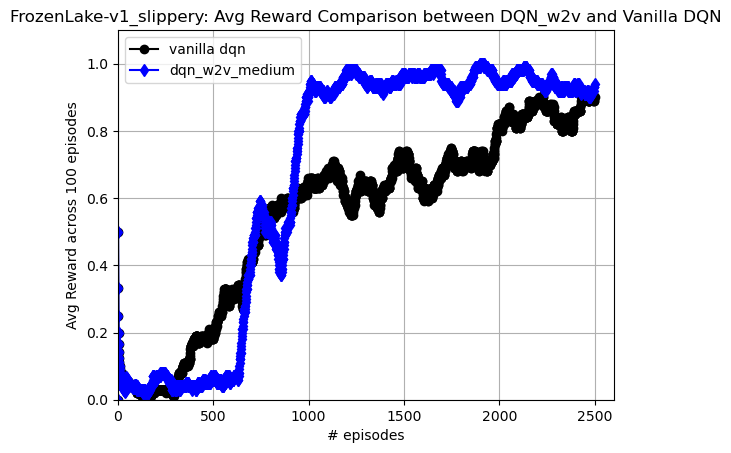

In [5]:
curve1 = np.load(f"{runs_folder_path}/rewards_dqn_{env_name}_map_size_{env_dim}_stochastic_{True}_seed_{19}.npy")
# curve_perfect = np.load(f"{runs_folder_path}/rewards_w2v_dqn_modified_perfect_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{True}_seed_{19}_epochs_{60}.npy")
curve_medium = np.load(f"{runs_folder_path}/rewards_w2v_dqn_modified_medium_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{True}_seed_{19}_epochs_{60}.npy")
# curve_random = np.load(f"{runs_folder_path}/rewards_w2v_dqn_modified_random_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{True}_seed_{19}_epochs_{60}.npy")

plt.figure(1)
plt.plot(range(args.n_episodes), curve1, label = 'vanilla dqn', linestyle='-', marker='o', color='k')
plt.plot(range(args.n_episodes), curve_medium, label = 'dqn_w2v_medium', linestyle='-', marker='d', color='b')
plt.title(f"{env_name}_slippery: Avg Reward Comparison between DQN_w2v and Vanilla DQN")
plt.xlabel("# episodes")
plt.ylabel("Avg Reward across 100 episodes")
plt.legend()
plt.axis([0, 2600, 0, 1.1])
plt.grid(True)
# plt.show()
plt.savefig(f"{runs_folder_path}/comparison_w2v_dqn_modified_medium_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{True}_seed_{19}_epochs_{60}.jpg")

## Case 2: Stochastic = False, variation across seeds = {6, 19, 42}


In [6]:
seeds = [6, 19, 42]
matrix_dqn = np.zeros((len(seeds), args.n_episodes)) # creates a matrix of size = # seeds x 2500
matrix_w2v_medium = np.zeros((len(seeds), args.n_episodes))
# matrix_w2v_random = np.zeros((len(seeds), args.n_episodes))
# matrix_w2v_perfect = np.zeros((len(seeds), args.n_episodes))

for idx, seedno in enumerate(seeds):
    matrix_dqn[idx,:] = np.load(f"{runs_folder_path}/rewards_dqn_{env_name}_map_size_{env_dim}_stochastic_{False}_seed_{seedno}.npy")
    matrix_w2v_medium[idx,:] = np.load(f"{runs_folder_path}/rewards_w2v_dqn_modified_medium_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{False}_seed_{seedno}_epochs_{60}.npy")
    # matrix_w2v_perfect[idx,:] = np.load(f"{runs_folder_path}/rewards_w2v_dqn_modified_perfect_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{False}_seed_{seedno}_epochs_{60}.npy")
    # matrix_w2v_random[idx,:] = np.load(f"{runs_folder_path}/rewards_w2v_dqn_modified_random_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{False}_seed_{seedno}_epochs_{60}.npy")
# end for loading the files

curve1 = np.mean(matrix_dqn, axis=0)
curve_medium = np.mean(matrix_w2v_medium, axis=0)

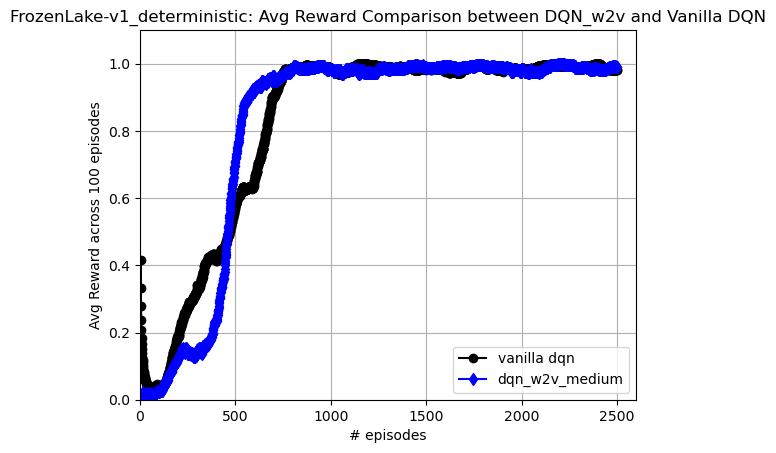

In [8]:
plt.figure(2)
plt.plot(range(args.n_episodes), curve1, label = 'vanilla dqn', linestyle='-', marker='o', color='k')
plt.plot(range(args.n_episodes), curve_medium, label = 'dqn_w2v_medium', linestyle='-', marker='d', color='b')
plt.title(f"{env_name}_deterministic: Avg Reward Comparison between DQN_w2v and Vanilla DQN")
plt.xlabel("# episodes")
plt.ylabel("Avg Reward across 100 episodes")
plt.legend()
plt.axis([0, 2600, 0, 1.1])
plt.grid(True)
# plt.show()
plt.savefig(f"{runs_folder_path}/comparison_w2v_dqn_modified_medium_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{False}_multiple_seeds_epochs_{60}.jpg")


## Case 3: S = False, seed = 42, variation across all 3 types of w2v

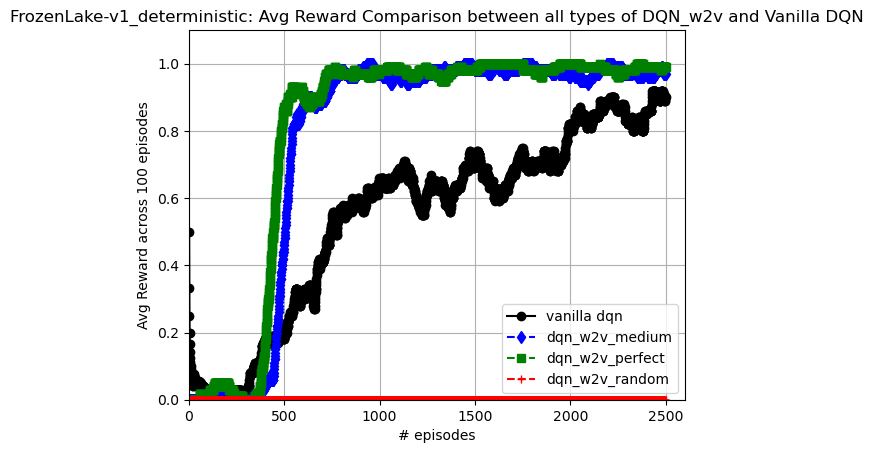

In [24]:
curve1 = np.load(f"{runs_folder_path}/rewards_dqn_{env_name}_map_size_{env_dim}_stochastic_{True}_seed_{19}.npy")
curve_perfect = np.load(f"{runs_folder_path}/rewards_w2v_dqn_modified_perfect_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{False}_seed_{42}_epochs_{50}.npy")
curve_medium = np.load(f"{runs_folder_path}/rewards_w2v_dqn_modified_medium_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{False}_seed_{42}_epochs_{60}.npy")
curve_random = np.load(f"{runs_folder_path}/rewards_w2v_dqn_modified_random_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{False}_seed_{42}_epochs_{60}.npy")

plt.figure(3)
plt.plot(range(args.n_episodes), curve1, label = 'vanilla dqn', linestyle='-', marker='o', color='k')
plt.plot(range(args.n_episodes), curve_medium, label = 'dqn_w2v_medium', linestyle='--', marker='d', color='b')
plt.plot(range(args.n_episodes), curve_perfect, label = 'dqn_w2v_perfect', linestyle='--', marker='s', color='g')
plt.plot(range(args.n_episodes), curve_random, label = 'dqn_w2v_random', linestyle='--', marker='+', color='r')
plt.title(f"{env_name}_deterministic: Avg Reward Comparison between all types of DQN_w2v and Vanilla DQN")
plt.xlabel("# episodes")
plt.ylabel("Avg Reward across 100 episodes")
plt.legend()
plt.axis([0, 2600, 0, 1.1])
plt.grid(True)
# plt.show()
plt.savefig(f"{runs_folder_path}/comparison_w2v_dqn_all_modified_w2v_embed_dim_{embed_dim}_{env_name}_map_size_{env_dim}_stochastic_{False}_seed_{42}_epochs_{60}.jpg")

## Comparison of effect of w2v_epochs on w2v performance
We vary the number of epochs for which w2v is trained while keeping the embedding dimension fixed 